# Step-1 do a rough test that the new instruction generators are working

In [33]:
import sys
sys.path.append('..')
from surface_erasure_decoding import *
from IPython.display import clear_output

d = 5
after_cz_error_model = get_2q_error_model(p_e=0.09,
                                            p_z_shift=0, 
                                            p_p=0.002)
builder = easure_circ_builder(rounds = d,
                                distance= d,
                                after_cz_error_model=after_cz_error_model,
                                measurement_error=0
                                )
builder.generate_helper()
builder.gen_erasure_conversion_circuit()

shots = 100

sampler = builder.erasure_circuit.compile_sampler()#expensive step, 16s for d13, 4s for d11, 0.7s for d9
meas_samples = sampler.sample(shots=shots)
converter = builder.erasure_circuit.compile_m2d_converter() # Expensive step

det_samples, actual_obs_chunk = converter.convert(measurements=meas_samples,
                                                        separate_observables=True)
num_errors = 0
for i in range(shots):
    predicted  = builder.decode_by_generate_new_circ(det_samples[i],'S',meas_samples[i])
    num_errors += actual_obs_chunk[i][0] != predicted
    clear_output(wait=True)
    print(f'decoding finished {100*i/shots}%')

print(f"error/shots = {num_errors}/{shots}")

decoding finished 99.0%
error/shots = 9/100


In [34]:
shots = 5
t0 = time.time()
sampler = builder.erasure_circuit.compile_sampler()#expensive step, 16s for d13, 4s for d11, 0.7s for d9

t1 = time.time()
meas_samples = sampler.sample(shots=shots)
t15 = time.time()
converter = builder.erasure_circuit.compile_m2d_converter() # Expensive step

t2 = time.time()
det_samples, actual_obs_chunk = converter.convert(measurements=meas_samples,
                                                        separate_observables=True)
t3 = time.time()
# Decode
new_circ_num_errors = 0
# normal_circ_num_errors = 0
for i in range(shots):
    predicted  = builder.decode_by_generate_new_circ(det_samples[i],'S',meas_samples[i])
    new_circ_num_errors += actual_obs_chunk[i][0] != predicted

    # predicted = builder.decode_without_changing_weights(det_samples[i],'S',meas_samples[i])
    # normal_circ_num_errors += actual_obs_chunk[i][0] != predicted

    clear_output(wait=True)
    print(f'decoding finished {100*i/shots}%')

t4 = time.time()

decoding finished 80.0%


# $A_{e,p}(p_e, p_p) = \binom{n_e}{e} p_e^e (1 - p_e)^{n_e - e} \times \binom{n_p}{p} p_p^t (1 - p_p)^{n_p - p}$

where $n_e$, $n_p$ is the total number of potential erasure/DEPOLARIZE2 error locations. 

For the circuit concerned, we have d noisy rounds, so there's $4*((d-1)^2+d)$ 2-qubit gates per round, and a total of $4d*((d-1)^2+d)$ 2-qubit gates

# Let's test if my importance sampling works!

In [38]:
import sys
sys.path.append('..')
from surface_erasure_decoding import *
from IPython.display import clear_output


def generate_bool_array(tot, choose):
    array = np.zeros(tot, dtype=bool)
    indices = np.random.choice(tot, choose, replace=False)
    assert len(indices) == choose
    array[indices] = True
    return array

def get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p):
    # Calculate binomial coefficients
    binom_e = math.comb(num_dice_e, num_e_flipped)
    binom_p = math.comb(num_dice_p, num_p_flipped)
    
    prob_e = (p_e ** num_e_flipped) * ((1 - p_e) ** (num_dice_e - num_e_flipped))
    prob_p = (p_p ** num_p_flipped) * ((1 - p_p) ** (num_dice_p - num_p_flipped))
    
    # Calculate the weight
    weight = binom_e * prob_e * binom_p * prob_p
    
    return weight

shots = 50
d = 5

p_e=0.08
p_p=0.0033
after_cz_error_model = get_2q_error_model(p_e=p_e,
                                        p_p=p_p)
builder = easure_circ_builder(rounds = d,
                                distance= d,
                                after_cz_error_model=after_cz_error_model,
                                measurement_error=0
                                )
builder.generate_helper()
builder.gen_dummy_circuit()

# Step-1 get tot_e, tot_p
non_trivial_gate_error_models = [attr_value for attr_name, attr_value in vars(builder).items() if isinstance(attr_value, GateErrorModel) and not  attr_value.trivial]
assert len(non_trivial_gate_error_models) == 1

tot_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].dummy_generator.num_qubit_called
tot_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].dummy_generator.num_qubit_called

num_qubit_per_dice_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].deterministic_generator.num_qubit_per_dice
num_qubit_per_dice_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].deterministic_generator.num_qubit_per_dice

num_dice_e = int(tot_e/num_qubit_per_dice_e)
num_dice_p = int(tot_p/num_qubit_per_dice_p)

builder.gen_erasure_conversion_circuit()
erasure_circ_next_ancilla_qubit_index = builder.next_ancilla_qubit_index_in_list[0]
converter = builder.erasure_circuit.compile_m2d_converter()

num_dice_e, num_dice_p

(800, 400)

100%|██████████| 200/200 [00:00<00:00, 1218.12it/s]


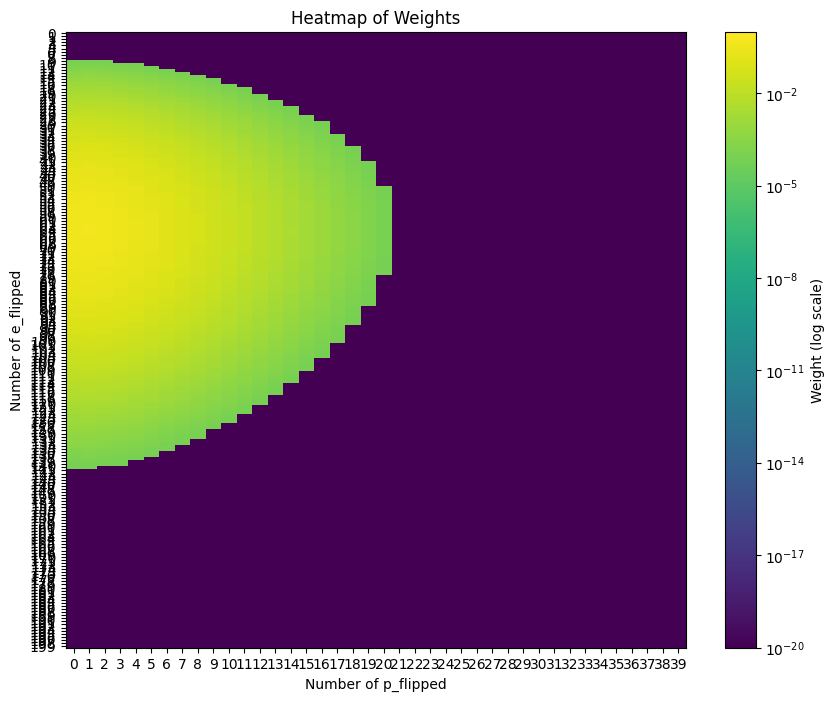

In [56]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm

# Define the ranges for num_e_flipped and num_p_flipped
num_e_flipped_range = np.arange(0, 200,1)
num_p_flipped_range = np.arange(0, 40, 1)
 
# Initialize the weight matrix
weights = np.zeros((len(num_e_flipped_range), len(num_p_flipped_range)))

# Calculate weights for each combination of num_e_flipped and num_p_flipped
for i, num_e_flipped in enumerate(tqdm(num_e_flipped_range)):
    for j, num_p_flipped in enumerate(num_p_flipped_range):
        weights[i, j] = get_weight(num_dice_e, num_dice_p, num_e_flipped, num_p_flipped, p_e, p_p)

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(weights, norm=LogNorm(vmin=1e-20,vmax = 1), origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(label='Weight (log scale)')
plt.xlabel('Number of p_flipped')
plt.ylabel('Number of e_flipped')
plt.title('Heatmap of Weights')
plt.xticks(ticks=np.arange(len(num_p_flipped_range)), labels=num_p_flipped_range)
plt.yticks(ticks=np.arange(len(num_e_flipped_range)), labels=num_e_flipped_range)

# plt.xlim(0,200)
# plt.ylim(0,200)

plt.show()


In [57]:
num_e_flipped = 90
num_p_flipped = 3
weight = get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p)
num_errors = 0

for i in range(shots):

    # contrary to generating erasure conversion circuit where I sync a single measurement array with multiple GateErrorModels, 
    #   here I manually set the dice for each unique mechanism
    e_dice_sample = generate_bool_array(num_dice_e, num_e_flipped)
    p_dice_sample = generate_bool_array(num_dice_p, num_p_flipped)

    non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].next_dice_index_in_list = [0]
    non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].next_dice_index_in_list = [0]

    non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].single_dice_sample = e_dice_sample
    non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].single_dice_sample = p_dice_sample

    builder.deterministic_circuit = stim.Circuit()
    builder.gen_circuit(builder.deterministic_circuit,mode='deterministic')
    builder.deterministic_circuit.append("MZ", 
                                np.arange(2*(builder.distance+1)**2, erasure_circ_next_ancilla_qubit_index, dtype=int)
                                )  # Measure the virtual erasure ancilla qubits
    
    sampler = builder.deterministic_circuit.compile_sampler()
    meas_samples = sampler.sample(shots=1)
    det_samples, actual_obs_chunk = converter.convert(measurements=meas_samples,
                                                            separate_observables=True)
    
    predicted  = builder.decode_by_generate_new_circ(det_samples[0],'S',meas_samples[0])
    num_errors += actual_obs_chunk[0][0] != predicted
    
    clear_output(wait=True)
    print(f'decoding finished {100*i/shots}%')


print(f"error/shots = {num_errors}/{shots}, this config has weight = {weight}")

decoding finished 98.0%
error/shots = 29/50, this config has weight = 2.6539065656402323e-05


In [59]:
num_e_flipped = 30
num_p_flipped = 3
weight = get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p)
num_errors = 0

for i in range(shots):

    # contrary to generating erasure conversion circuit where I sync a single measurement array with multiple GateErrorModels, 
    #   here I manually set the dice for each unique mechanism
    e_dice_sample = generate_bool_array(num_dice_e, num_e_flipped)
    p_dice_sample = generate_bool_array(num_dice_p, num_p_flipped)

    non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].next_dice_index_in_list = [0]
    non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].next_dice_index_in_list = [0]

    non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].single_dice_sample = e_dice_sample
    non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].single_dice_sample = p_dice_sample

    builder.deterministic_circuit = stim.Circuit()
    builder.gen_circuit(builder.deterministic_circuit,mode='deterministic')
    builder.deterministic_circuit.append("MZ", 
                                np.arange(2*(builder.distance+1)**2, erasure_circ_next_ancilla_qubit_index, dtype=int)
                                )  # Measure the virtual erasure ancilla qubits
    
    sampler = builder.deterministic_circuit.compile_sampler()
    meas_samples = sampler.sample(shots=1)
    det_samples, actual_obs_chunk = converter.convert(measurements=meas_samples,
                                                            separate_observables=True)
    
    predicted  = builder.decode_by_generate_new_circ(det_samples[0],'S',meas_samples[0])
    num_errors += actual_obs_chunk[0][0] != predicted
    
    clear_output(wait=True)
    print(f'decoding finished {100*i/shots}%')


print(f"error/shots = {num_errors}/{shots}, this config has weight = {weight}")

decoding finished 98.0%
error/shots = 1/50, this config has weight = 4.4633163610509276e-08
